[View in Colaboratory](https://colab.research.google.com/github/usernaamee/learning-good-representations/blob/master/cifar10_conv_ae.ipynb)

In [5]:
import numpy as np
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, \
  UpSampling2D, Reshape, Flatten, BatchNormalization, Dropout, Activation

Using TensorFlow backend.


In [6]:
conv_ae = Sequential()
for l_idx in range(3):
  conv_ae.add(Conv2D(32*(l_idx+1), 3, strides=2, padding='same', input_shape=(32, 32, 3)))
  conv_ae.add(Conv2D(32*(l_idx+1), 3, padding='same'))
  conv_ae.add(BatchNormalization())
  conv_ae.add(Activation('relu'))
  conv_ae.add(Dropout(0.5))
for l_idx in range(3):
  conv_ae.add(UpSampling2D())
  conv_ae.add(Conv2DTranspose(64, 3, padding='same'))
  conv_ae.add(Conv2DTranspose(64, 3, padding='same'))
  conv_ae.add(Activation('relu'))
conv_ae.add(Conv2D(3, 1, activation='tanh'))
conv_ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
__________

In [7]:
((xtrain, ytrain), (xtest, ytest)) = cifar10.load_data()
print(xtrain.shape, xtest.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    rotation_range=45.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.3
)
datagen.fit(xtrain)

In [10]:
conv_ae.compile(loss='mse', optimizer='adam')
n_epochs = 10

for epoch in range(n_epochs):
  training_loss = []
  validation_loss = []
  counter = 0
  print ('\nEpoch: {}/{}'.format(epoch+1,n_epochs))
  for xb, yb in datagen.flow(xtrain, ytrain, batch_size=300, subset="training"):
    tloss = conv_ae.train_on_batch(xb, xb)
    training_loss.append(tloss)
    if (counter+1)%30==0:
      print(' + {} training loss: {}'.format(counter+1, np.mean(training_loss)))
    if counter+1 == 150:
      break
    counter += 1
  counter = 0
  for xb, yb in datagen.flow(xtrain, ytrain, batch_size=1000, subset="validation"):
    vloss = conv_ae.test_on_batch(xb, xb)
    validation_loss.append(vloss)
    if (counter+1)%3==0:
      print(' + {} validation loss: {}'.format(counter+1, np.mean(validation_loss)))
    if counter+1 == 15:
      break
    counter += 1
  print ('Epoch: {}/{} -> {}\t{}'.format(epoch+1,n_epochs, np.mean(training_loss), np.mean(validation_loss)))


Epoch: 1/10
 + 30 training loss: 0.24370180070400238
 + 60 training loss: 0.23477187752723694
 + 90 training loss: 0.23158489167690277
 + 120 training loss: 0.22961242496967316
 + 150 training loss: 0.22786326706409454
 + 3 validation loss: 0.19223947823047638
 + 6 validation loss: 0.19522391259670258
 + 9 validation loss: 0.1948145478963852
 + 12 validation loss: 0.19361113011837006
 + 15 validation loss: 0.19285358488559723
Epoch: 1/10 -> 0.22786326706409454	0.19285358488559723

Epoch: 2/10
 + 30 training loss: 0.2223023772239685
 + 60 training loss: 0.22127804160118103
 + 90 training loss: 0.2208120971918106
 + 120 training loss: 0.21986158192157745
 + 150 training loss: 0.2188497930765152
 + 3 validation loss: 0.18924552202224731
 + 6 validation loss: 0.1872367411851883
 + 9 validation loss: 0.18802078068256378
 + 12 validation loss: 0.18682177364826202
 + 15 validation loss: 0.18728245794773102
Epoch: 2/10 -> 0.2188497930765152	0.18728245794773102

Epoch: 3/10
 + 30 training loss

In [11]:
testgen = ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
)
testgen.fit(xtest)

test_loss = []
counter = 0
for xb, yb in testgen.flow(xtest, ytest, batch_size=1000):
    tloss = conv_ae.test_on_batch(xb, xb)
    test_loss.append(tloss)
    if counter == 10:
      break
    counter += 1
print('Test loss: {}'.format(np.mean(test_loss)))

Test loss: 0.19410990178585052


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

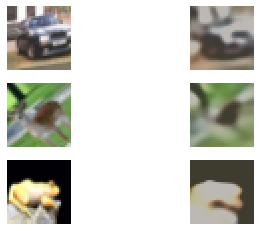

In [13]:
imgs, _ = next(datagen.flow(xtest, ytest, batch_size=3))
genimgs = conv_ae.predict(imgs)
imgs *= datagen.std
imgs += datagen.mean
imgs = imgs.astype(np.uint8)
genimgs *= datagen.std
genimgs += datagen.mean
genimgs = genimgs.astype(np.uint8)

fig = plt.figure()

for i in range(3):
  ax = fig.add_subplot(3, 2, i*2+1)
  ax.grid(False)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow(imgs[i])
  ax = fig.add_subplot(3, 2, i*2+2)
  ax.grid(False)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow(genimgs[i])